# DEA Coastlines raster generation <img align="right" src="https://github.com/GeoscienceAustralia/dea-notebooks/raw/develop/Supplementary_data/dea_logo.jpg">

This code conducts raster generation for DEA Coastlines:

* Load stack of all available Landsat 5, 7 and 8 satellite imagery for a location using [ODC Virtual Products](https://docs.dea.ga.gov.au/notebooks/Frequently_used_code/Virtual_products.html)
* Convert each satellite image into a remote sensing water index (MNDWI)
* For each satellite image, model ocean tides into a 2 x 2 km grid based on exact time of image acquisition
* Interpolate tide heights into spatial extent of image stack
* Mask out high and low tide pixels by removing all observations acquired outside of 50 percent of the observed tidal range centered over mean sea level
* Combine tidally-masked data into annual median composites from 1988 to the present representing the coastline at approximately mean sea level

This is an interactive version of the code intended for prototyping; to run this analysis at scale, use the [`deacoastlines_generation.py`](deacoastlines_generation.py) Python script.

**Compatability:**
```
module use /g/data/v10/public/modules/modulefiles
module load dea/20200713
pip install --user ruptures
pip install --user git+https://github.com/mattijn/topojson/
pip install --user --upgrade --extra-index-url="https://packages.dea.ga.gov.au" odc-algo
pip install --upgrade dask==2021.1.1
```
---

In [ ]:
# pip install dea-tools

In [ ]:
# pip install --user topojson

In [ ]:
# pip install --user --upgrade --extra-index-url="https://packages.dea.ga.gov.au" odc-algo==0.2.dev2238

In [2]:
# pip install --upgrade dask==2021.1.1

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 891 kB 8.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Getting started


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [3]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import os
import sys
import datetime
import datacube
import geopandas as gpd
import multiprocessing
import xarray as xr
from functools import partial
import odc.algo
import numpy as np
from datacube.utils.geometry import Geometry
from dea_tools.dask import create_local_dask_cluster

import sys
sys.path.insert(0, '..')
import dea_coastlines.raster

dc = datacube.Datacube(app='DEA_Coastlines')

# client = create_local_dask_cluster(return_client=True)


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load supplementary data

In [4]:
study_area = 8335
raster_version = 'refactor_test'
vector_version = 'refactor_test'

# Tide points are used to model tides across the extent of the satellite data
points_gdf = gpd.read_file('../data/raw/tide_points_coastal.geojson')

# Albers grid cells used to process the analysis
gridcell_gdf = (gpd.read_file('../data/raw/50km_albers_grid_clipped.geojson')
                .to_crs(epsg=4326)
                .set_index('id')
                .loc[[study_area]])

## Loading data
### Create query


In [5]:
# Create query
geopoly = Geometry(gridcell_gdf.iloc[0].geometry, crs=gridcell_gdf.crs)
query = {'geopolygon': geopoly,  #.buffer(0.05),
         'time': ('2017', '2020'),  # 1987, 2020
         'dask_chunks': {'time': 1, 'x': 2000, 'y': 2000}}


### Load virtual product

In [6]:
# Load virtual product
ds = dea_coastlines.raster.load_mndwi(
    dc,
    query,
    yaml_path='../configs/deacoastlines_virtual_products_v1.0.0.yaml',
    product_name='ls_nbart_mndwi')
ds

,Array,Chunk
Bytes,393.90 MB,1.68 MB
Shape,"(235, 873, 480)","(1, 873, 480)"
Count,11752 Tasks,235 Chunks
Type,float32,numpy.ndarray


## Tidal modelling
### Model tides at point locations

../dea_coastlines/raster.py:198: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x_vals = subset_gdf.geometry.centroid.x
../dea_coastlines/raster.py:199: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  y_vals = subset_gdf.geometry.centroid.y


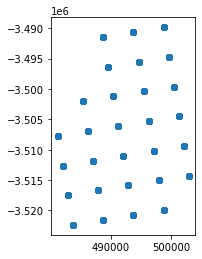

In [7]:
tidepoints_gdf = dea_coastlines.raster.model_tides(ds, points_gdf)
tidepoints_gdf.plot()

### Interpolate tides into each satellite timestep

In [ ]:
pool = multiprocessing.Pool(multiprocessing.cpu_count() - 1)
print(f'Parallelising {multiprocessing.cpu_count() - 1} processes')
out_list = pool.map(partial(dea_coastlines.raster.interpolate_tide,
                            tidepoints_gdf=tidepoints_gdf,
                            factor=50), 
                    iterable=[group for (i, group) in ds.groupby('time')])
# pool.close()
# pool.join()

# Combine to match the original dataset
ds['tide_m'] = xr.concat(out_list, dim=ds['time'])

In [ ]:
import matplotlib.pyplot as plt

# Plot 
ds_i = ds['tide_m'].isel(time=18).compute()
ds_i.plot.imshow(robust=True, 
                 cmap='viridis', 
                 size=12, 
                 vmin=ds_i.min().item(), 
                 vmax=ds_i.max().item())
tidepoints_gdf.loc[str(ds_i.time.values)[0:10]].plot(ax=plt.gca(), 
                                                     column='tide_m', 
                                                     cmap='viridis', 
                                                     markersize=100,
                                                     edgecolor='black',
                                                     vmin=ds_i.min().item(),
                                                     vmax=ds_i.max().item())


In [7]:
# Determine tide cutoff
tide_cutoff_buff = (
    (ds['tide_m'].max(dim='time') - ds['tide_m'].min(dim='time')) * 0.25)
tide_cutoff_min = 0.0 - tide_cutoff_buff
tide_cutoff_max = 0.0 + tide_cutoff_buff

## Generate yearly composites

In [ ]:
# If output folder doesn't exist, create it
output_dir = f'../data/processed/raster/{raster_version}/{study_area}_{raster_version}'
os.makedirs(output_dir, exist_ok=True)

# Iterate through each year and export annual and 3-year gapfill composites
dea_coastlines.raster.export_annual_gapfill(ds, output_dir, tide_cutoff_min,
                                            tide_cutoff_max)

Processing 2017
Processing 2018
Processing 2019


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** For assistance with any of the Python code or Jupyter Notebooks in this repository, please post a [Github issue](https://github.com/GeoscienceAustralia/DEACoastLines/issues/new). For questions or more information about this product, sign up to the [Open Data Cube Slack](https://join.slack.com/t/opendatacube/shared_invite/zt-d6hu7l35-CGDhSxiSmTwacKNuXWFUkg) and post on the [`#dea-coastlines`](https://app.slack.com/client/T0L4V0TFT/C018X6J9HLY/details/) channel.

**Last modified:** July 2021